# Hybrid Search for E-Commerce with Pinecone


Hybrid vector search is combination of traditional keyword search and modern dense vector search. It has emerged as a powerful tool for e-commerce companies looking to improve the search experience for their customers. By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.

Pinecone's new hybrib index allows you to seamlessly perform hybrid search for e-commerce or in any other context. This notebook demonstrates how to use the new hybrid search feature to improve e-commerce search.

## Install Dependencies

First, let's import the necessary libraries


In [ ]:
!pip install datasets transformers sentence-transformers requests

## Connect to Pinecone

The hybrid vector index is currently not available in Pinecone python client. So, we will use the Pinecone REST API to communicate with the new index. The ```HybridPinecone``` class below gives you a similar interface to the python-client to communicate with the new index.

In [1]:
import requests

In [2]:
class HybridPinecone:
    # initializes the HybridPinecone object
    def __init__(self, api_key, environment):
        # make environment, headers and project_id available across all the function within the class
        self.environment = environment
        self.headers = {'Api-Key': api_key}
        # get project_id
        res = requests.get(
            f"https://controller.{self.environment}.pinecone.io/actions/whoami",
            headers=self.headers
        )
        self.project_id = res.json()['project_name']
        self.host = None

    # creates an index in pinecone vector database
    def create_index(self, index_name, dimension, metric, pod_type):
        # index specification
        params = {
            'name': index_name,
            'dimension': dimension,
            'metric': metric,
            'pod_type': pod_type
        }
        # sent a post request with the headers and parameters to pinecone database
        res = requests.post(
            f"https://controller.{self.environment}.pinecone.io/databases",
            headers=self.headers,
            json=params
        )
        # return the creation status
        return res
    
    # get the project_id for the index and update self.host variable
    def connect_index(self, index_name):
        # set the self.host variable
        self.host = f"{index_name}-{self.project_id}.svc.{self.environment}.pinecone.io"
        res = self.describe_index_stats()
        # return index related information as json
        return res
    
    def describe_index(self, index_name):
        # send a get request to pinecone database to get index description
        res = requests.get(
            f"https://controller.{self.environment}.pinecone.io/databases/{index_name}",
            headers=self.headers
        )
        return res.json()

    # returns description of the index
    def describe_index_stats(self):
        # send a get request to pinecone database to get index description
        res = requests.get(
            f"https://{self.host}/describe_index_stats",
            headers=self.headers
        )
        # return the index description as json
        return res.json()

    # uploads the documents to pinecone database
    def upsert(self, vectors):
        # send a post request with vectors to pinecone database
        res = requests.post(
            f"https://{self.host}/hybrid/vectors/upsert",
            headers=self.headers,
            json={'vectors': vectors}
        )
        # return the http response status
        return res

    # searches pinecone database with the query
    def query(self, query):
        # sends a post request to hybrib vector index with the query dict
        res = requests.post(
            f"https://{self.host}/hybrid/query",
            headers=self.headers,
            json=query
        )
        # returns the result as json
        return res.json()

    # deletes an index in pinecone database
    def delete_index(self, index_name):
        # sends a delete request
        res = requests.delete(
            f"https://controller.{self.environment}.pinecone.io/databases/{index_name}",
            headers=self.headers
        )
        # returns the http response status
        return res

Let's initiate a connection and create an index. For this, we need a [free API key](https://app.pinecone.io/), and then we initialize the connection like so:

In [3]:
# initialize an instance of HybridPinecone class
pinecone = HybridPinecone(
    api_key = "YOUR_API_KEY",
    environment = "us-west1-gcp"
)

We specify the metric type as "dotproduct" and dimension as 512 because the retriever we use to generate context embeddings outputs 512-dimension vectors.

In [6]:
# choose a name for your index
index_name = "hybrid-image-search"

# create the index
pinecone.create_index(
   index_name = index_name,
   dimension = 512,
   metric = "dotproduct",
   pod_type = "s1h"
)

Now we have created the hybrid vector index using the `"s1h"` hybrid `pod_type`. To connect to the index we must wait until it is ready, we can check it's status like so:

In [7]:
pinecone.describe_index(index_name)

{'database': {'name': 'hybrid-image-search',
  'index_type': 'approximated',
  'metric': 'dotproduct',
  'dimension': 512,
  'replicas': 1,
  'shards': 1,
  'pods': 1,
  'pod_type': 's1h',
  'index_config': {'approximated': {'k_bits': 512}}},
 'status': {'waiting': [],
  'crashed': [],
  'host': 'hybrid-image-search-load-test.svc.internal-alpha.pinecone.io',
  'port': 433,
  'state': 'Ready',
  'ready': True}}

If the `state` is `'Ready'` we can continue and connect to the index like so:

In [5]:
pinecone.connect_index(index_name)

{'namespaces': {}, 'dimension': 512, 'indexFullness': 0, 'totalVectorCount': 0}

# Load Dataset

We will work with a subset of the [Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [8]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

We will first assign the images and metadata into separate variables and then convert the metadata into a pandas dataframe.

In [9]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

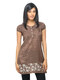

In [10]:
# display a product image
images[900]

In [11]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We need both sparse and dense vectors to perform hybrid search. We will use all the metadata fields except for the `id` and `year` to create sparse vectors and the product images to create dense vectors.

## Sparse Vectors

A simple way to create sparse vectors is to use a tokenizer from Huggingface. You can use any other approach. As long as the final output is a dictionary of key to frequency values, you are good to go. We will use the BERT Tokenizer in this demo and take the token ids to create the dictionary.

In [12]:
from transformers import BertTokenizerFast

# load bert tokenizer from huggingface
tokenizer = BertTokenizerFast.from_pretrained(
    'bert-base-uncased'
)

Let's create a test sparse vector using a `productDisplayName`.

In [13]:
context = metadata['productDisplayName'][0]

In [14]:
# tokenize the text passage
inputs = tokenizer(
    context, padding=True, truncation=True,
    max_length=512
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
# extract the input ids
input_ids = inputs['input_ids']
input_ids

[101, 13170, 4638, 2273, 3212, 2630, 3797, 102]

Now we need to convert this into a dictionary of key to frequency values.

In [16]:
from collections import Counter

# convert the input_ids list to a dictionary of key to frequency values
sparse_vec = dict(Counter(input_ids))
sparse_vec

{101: 1, 13170: 1, 4638: 1, 2273: 1, 3212: 1, 2630: 1, 3797: 1, 102: 1}

Let's write a function to do this in batches. Notice that we are removing some keys from the dictionary. These are special tokens from the tokenizer which we do not really need when creating sparse vectors.

In [17]:
def build_dict(input_batch):
  # store a batch of sparse embeddings
    sparse_emb = []
    # iterate through input batch
    for token_ids in input_batch:
        # convert the input_ids list to a dictionary of key to frequency values
        d = dict(Counter(token_ids))
        # remove special tokens and append sparse vectors to sparse_emb list
        sparse_emb.append({key: d[key] for key in d if key not in [101, 102, 103, 0]})
    # return sparse_emb list
    return sparse_emb

Let's write another function to help us generate sparse vectors in batches. 

In [18]:
def generate_sparse_vectors(batch):
    # create batch of input_ids
    inputs = tokenizer(
            batch, padding=True,
            truncation=True,
            max_length=512
    )['input_ids']
    # create sparse dictionaries
    sparse_embeds = build_dict(inputs)
    return sparse_embeds

## Dense Vectors

We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

In [19]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

SentenceTransformer(
  (0): CLIPModel()
)

In [20]:
# function to generate dense vectors in batches
def generate_dense_vectors(batch):
    dense_vec = model.encode(batch).tolist()
    return dense_vec

The model gives us a `512` dimensional dense vector.

## Upsert Documents

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [27]:
from tqdm.auto import tqdm

batch_size = 32

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse vectors
    sparse_embeds = generate_sparse_vectors(meta_batch)
    # create dense vectors
    dense_embeds = generate_dense_vectors(img_batch)
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    vectors = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        vectors.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })

    # upload the documents to the new hybrid index
    pinecone.upsert(vectors)

# show index description after uploading the documents
pinecone.describe_index_stats()

{'namespaces': {'': {'vectorCount': 44072}},
 'dimension': 512,
 'indexFullness': 0.1,
 'totalVectorCount': 44072}

## Querying

Now we can query the index, providing the sparse and dense vectors, along with a weight for keyword relevance (“alpha”). `Alpha=1` will provide a purely semantic-based image search result and `alpha=0` will provide a purely keyword-based result equivalent to BM25. The default value is `0.5`.

Let's write some helper functions to execute queries and display the results.

In [21]:
def hybrid_query(question, top_k, alpha):
    # convert the question into a sparse vector
    sparse_vec = generate_sparse_vectors([question])
    # convert the question into a dense vector
    dense_vec = model.encode([question]).tolist()
    # set the query parameters to send to pinecone
    query = {
      "topK": top_k,
      "vector": dense_vec,
      "sparseVector": sparse_vec[0],
      "alpha": alpha,
      "includeMetadata": True
    }
    # query pinecone with the query parameters
    result = pinecone.query(query)
    # return search results as json
    return result

In [22]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()  
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

First, we will do a keyword search by setting the alpha value as 0. The hybrid index is using BM25 for this.


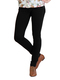
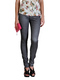
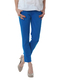
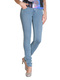
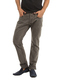
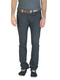
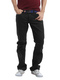
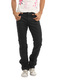
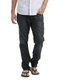
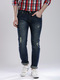
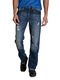
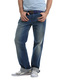
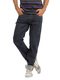
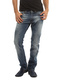

In [28]:
question = "dark blue french connection jeans for men"
# perform a keyword search
result = hybrid_query(question, top_k=14, alpha=0)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's take a look at the description of the result.

In [29]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Women Black Jeans
French Connection Women Black Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Grey Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Navy Washed Skinny Stretchable Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans


We can observe that the keyword search returned French Connection jeans but failed to rank the men's French Connection blue jeans higher. Now let's do a pure semantic image search by setting the alpha value to 1.


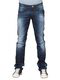
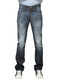
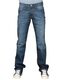
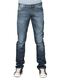
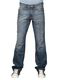
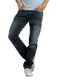
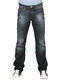
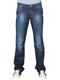
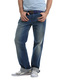
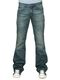
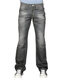
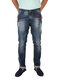
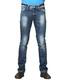
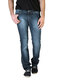

In [30]:
# perform a semantic image search
result = hybrid_query(question, top_k=14, alpha=1)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [31]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
Locomotive Men Lio Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Rafe Blue Jeans
Locomotive Men Barney Grey Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Spykar Men Style Essentials Kns 0542 Blue Jeans
Wrangler Men Blue Skanders Jeans


The semantic image search correctly returned blue jeans for men, but mostly failed to match the exact brand we are looking for — French Connection. Now let's set the alpha value to 0.07 to try a hybrid search.


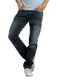
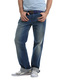
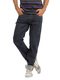
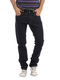
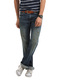
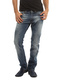
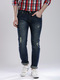
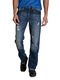
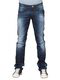
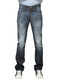
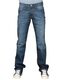
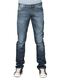
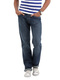
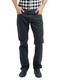

In [32]:
# perform a hybrid search
result = hybrid_query(question, top_k=14, alpha=0.07)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [33]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Blue Jeans
French Connection Navy Washed Skinny Stretchable Jeans
French Connection Men Blue Jeans
Locomotive Men Radley Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Cam Blue Jeans
Pepe Jeans Men Dark Blue Jeans
French Connection Men Blue Jeans


As we can see, a simple hybrid search has returned better results. Let's try more queries.


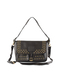
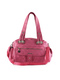
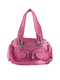
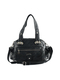
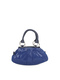
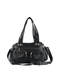
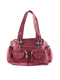
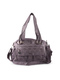
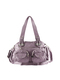
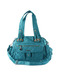
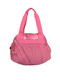
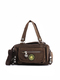
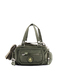
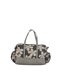

In [34]:
question = "small beige handbag for women"
# perform a keyword search search
result = hybrid_query(question, top_k=14, alpha=0)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)


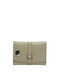
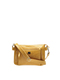
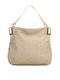
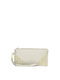
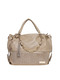
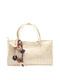
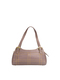
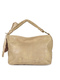
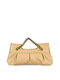
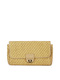
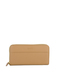
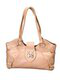
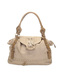
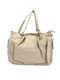

In [35]:
# perform a hybrid search
result = hybrid_query(question, top_k=14, alpha=0.65)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Here we see that when doing a keyword search, the result contains handbags from different colors. But the hybrid search gives us a much better result.

Let's run some more interesting queries. This time we will use a product image and a small description with [metadata filtering](https://docs.pinecone.io/docs/metadata-filtering) to get similar products. First, let's modify the `hybrid query` function a little bit and we then can move on with querying.

In [36]:
def hybrid_query(image, description, top_k, alpha, filter):
    # convert the question into a sparse vector
    sparse_vec = generate_sparse_vectors([description])
    # convert the image into a dense vector
    dense_vec = model.encode([image]).tolist()
    # set the query parameters to send to pinecone
    query = {
      "topK": top_k,
      "vector": dense_vec,
      "sparseVector": sparse_vec[0],
      "alpha": alpha,
      "filter": filter,
      "includeMetadata": True
    }
    # query pinecone with the query parameters
    result = pinecone.query(query)
    # return search results as json
    return result

We can now pass both image and text to the `hybrid_query` function along with a metadata filter. The function would first generate dense embedding for the image and sparse embedding for the description and then apply the metadata filter before doing the hybrid search. We will select few images and run the search.

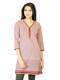

In [37]:
images[36254]


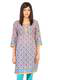
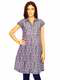
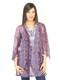
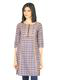
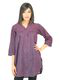
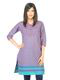
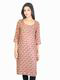
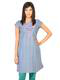
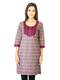
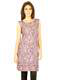
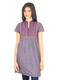
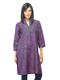
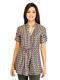
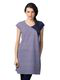

In [38]:
# perform a hybrid search with metadata filtering
result = hybrid_query(images[36254], "soft purple topwear", top_k=14, alpha=0.3, filter={"baseColour": "Purple"})
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

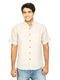

In [39]:
images[36256]


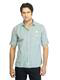
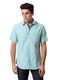
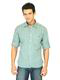
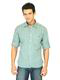
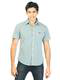
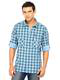
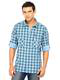
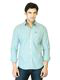
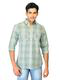
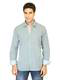
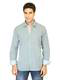
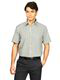
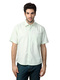
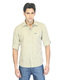

In [40]:
# perform a hybrid search with metadata filtering
result = hybrid_query(images[36256], "soft green color topwear", top_k=14, alpha=0.6, filter={"baseColour": "Green"})
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Here we did not specify the gender but the search results are accurate and we got products matching our query image and description.

# Delete the Index

In [ ]:
pinecone.delete_index(index_name)